# Create SpatialData objects from scratch

There might be situations in which one would like to benefit from the SpatialData ecosystem without neccecarily coming from a place where the readers from [spatialdata-io](https://spatialdata.scverse.org/projects/io/en/latest/) can be used to create the SpatialData objects. This notebook will show how to create SpatialData objects from scratch.

For this example, we'll create a `SpatialData` object from the objects that are being provided through [`Squidpy.datasets.visium_hne_image()`](https://squidpy.readthedocs.io/en/stable/api/squidpy.datasets.visium_hne_image.html#squidpy.datasets.visium_hne_image) and [`Squidpy.datasets.visium_hne_adata()`](https://squidpy.readthedocs.io/en/stable/api/squidpy.datasets.visium_hne_adata.html). To do so, we'll follow these steps:
1) Extract the image from the `Squidpy.ImageContainer` and use the class [`SpatialData.Image2DModel`](https://spatialdata.scverse.org/en/stable/api/models.html#spatialdata.models.Image2DModel) prepare the image to be used by `SpatialData`.
2) Extract the spot centers from the `AnnData` object and use the class [`SpatialData.ShapesModel`](https://spatialdata.scverse.org/en/stable/api/models.html#spatialdata.models.ShapesModel) to prepare the tabular information to be used by `SpatialData`.
3) Prepare and connect the `AnnData` to the rest of the data.
4) Create and visualise the `SpatialData` object to verify that it worked

## 1) Extract the image from the `Squidpy.ImageContainer`

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import spatialdata as sd
import spatialdata_plot as sdp  # noqa: F401
import squidpy as sq
from shapely.geometry import Point
from spatialdata.models import Image2DModel, ShapesModel, TableModel

sq_img = sq.datasets.visium_hne_image()
sq_img

/Users/tim.treis/anaconda3/envs/spatialdata-workshop/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


ImageContainer[shape=(11757, 11291), layers=['image']]

We can see that this function has downloaded the data and converted it into a `Squidpy.ImageContainer` object, which is a wrapper around a `xarray.Dataset`.

In [2]:
sq_img.data

<xarray.Dataset> Size: 398MB
Dimensions:  (z: 1, y: 11757, x: 11291, channels: 3)
Coordinates:
  * z        (z) <U20 80B 'V1_Adult_Mouse_Brain'
Dimensions without coordinates: y, x, channels
Data variables:
    image    (y, x, z, channels) uint8 398MB dask.array<chunksize=(11757, 11291, 1, 3), meta=np.ndarray>
Attributes:
    coords:       CropCoords(x0=0, y0=0, x1=0, y1=0)
    padding:      CropPadding(x_pre=0, x_post=0, y_pre=0, y_post=0)
    scale:        1.0
    mask_circle:  False

The actual image is stored in the `image` attribute of the `Squidpy.ImageContainer` object. We can extract it as a numpy array and create a `SpatialData.Image2DModel` object from it.

In [3]:
img = (
    sq_img.data.image.squeeze()  # get the xarray object  # select the image data  # remove the z dimension
    .transpose("channels", "y", "x")  # transpose to (cyx) for SpatialData
    .to_numpy()  # convert to numpy array
)
img

array([[[129, 129, 129, ..., 127, 128, 128],
        [130, 131, 130, ..., 128, 128, 128],
        [128, 129, 127, ..., 129, 128, 127],
        ...,
        [128, 131, 131, ..., 131, 131, 128],
        [130, 131, 131, ..., 132, 132, 129],
        [130, 132, 132, ..., 133, 133, 131]],

       [[134, 132, 132, ..., 129, 129, 130],
        [134, 135, 132, ..., 130, 130, 129],
        [136, 135, 132, ..., 131, 129, 129],
        ...,
        [132, 132, 131, ..., 133, 132, 129],
        [132, 132, 132, ..., 134, 132, 130],
        [132, 133, 133, ..., 135, 133, 131]],

       [[127, 127, 127, ..., 123, 125, 126],
        [127, 128, 128, ..., 125, 126, 124],
        [128, 128, 126, ..., 127, 126, 124],
        ...,
        [127, 128, 126, ..., 129, 128, 125],
        [127, 128, 126, ..., 133, 130, 127],
        [127, 127, 127, ..., 133, 131, 128]]], dtype=uint8)

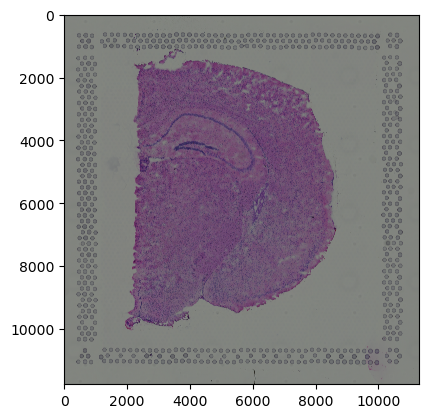

In [4]:
plt.imshow(img.transpose(1, 2, 0))  # matplotlib expects (x, y, c)

In [5]:
img_for_sdata = Image2DModel.parse(data=img, scale_factors=(2, 2, 2))  # this creates 4 downscaled images as well
img_for_sdata

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:  (c: 3, y: 11757, x: 11291)
│       Coordinates:
│         * c        (c) int64 24B 0 1 2
│         * y        (y) float64 94kB 0.5 1.5 2.5 3.5 ... 1.175e+04 1.176e+04 1.176e+04
│         * x        (x) float64 90kB 0.5 1.5 2.5 3.5 ... 1.129e+04 1.129e+04 1.129e+04
│       Data variables:
│           image    (c, y, x) uint8 398MB dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:  (c: 3, y: 5878, x: 5645)
│       Coordinates:
│         * c        (c) int64 24B 0 1 2
│         * y        (y) float64 47kB 1.0 3.0 5.0 ... 1.175e+04 1.175e+04 1.176e+04
│         * x        (x) float64 45kB 1.0 3.0 5.0 ... 1.129e+04 1.129e+04 1.129e+04
│       Data variables:
│           image    (c, y, x) uint8 100MB dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── DataTree('scale2')
│       Dimensions:  (c: 3, y: 2939, x: 2822)
│       Coordinates:
│         * c        (c) int64 24B 0 1 2
│         * y        (y) float64 24kB 2.0 6.001 10.0 ... 1.175e+04 1.175e+04 1.175e+04
│         * x        (x) float64 23kB 2.001 6.002 10.0 ... 1.128e+04 1.128e+04 1.129e+04
│       Data variables:
│           image    (c, y, x) uint8 25MB dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
└── DataTree('scale3')
        Dimensions:  (c: 3, y: 1469, x: 1411)
        Coordinates:
          * c        (c) int64 24B 0 1 2
          * y        (y) float64 12kB 4.002 12.01 20.01 ... 1.174e+04 1.175e+04
          * x        (x) float64 11kB 4.001 12.0 20.01 ... 1.127e+04 1.128e+04 1.129e+04
        Data variables:
            image    (c, y, x) uint8 6MB dask.array<chunksize=(3, 256, 256), meta=np.ndarray>

## 2) Extract the spot centers from the `AnnData` object

In [6]:
adata = sq.datasets.visium_hne_adata()
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In the old `Squidpy` interface, all spatial information was stored in the `AnnData` slots. We'll extract the spot centers from there. For Visium, it is sufficient to store the center of the spot circle and its radius.

In [7]:
centers = adata.obsm["spatial"]
centers

array([[8230, 7237],
       [4170, 1611],
       [2519, 8315],
       ...,
       [3276, 8435],
       [3069, 6639],
       [4720, 2090]])

### Calculate the spot radius
In this dataset we do not have information on the size of the spot radii, but we can compute it. Let's do this.
10x Genomics states

> [... each spot is 55 µm in diameter with a 100 µm center to center distance between spots.](https://kb.10xgenomics.com/hc/en-us/articles/360035487572-What-is-the-spatial-resolution-and-configuration-of-the-capture-area-of-the-Visium-v1-Gene-Expression-Slide)

We can use this information to calculate the approximate real radius of the spots in pixel.

In [8]:
spot_df = pd.concat(
    [adata.obs[["array_col", "array_row"]].reset_index(drop=True), pd.DataFrame(centers, columns=["x", "y"])],
    axis=1,
    ignore_index=True,
)
spot_df.columns = ["array_col", "array_row", "spot_center_x", "spot_center_y"]
spot_df

,array_col,array_row,spot_center_x,spot_center_y
0,102,50,8230,7237
1,43,3,4170,1611
2,19,59,2519,8315
3,94,14,7679,2927
4,28,42,3138,6280
...,...,...,...,...
2683,77,31,6509,4963
2684,42,58,4101,8195
2685,30,60,3276,8435
2686,27,45,3069,6639


Knowing that for a given row, consecutive spots are 100µm apart, let's compute the pixels to µm conversion factor.

In [9]:
fixed_row = spot_df.array_row.iloc[0].item()
cols = spot_df.query(f"array_row == {fixed_row}").array_col
min_col, max_col = cols.min().item(), cols.max().item()
xs = spot_df.query(f"array_row == {fixed_row}").spot_center_x
min_x, max_x = xs.min().item(), xs.max().item()

min_col, max_col, min_x, max_x

(16, 104, 2312, 8367)

In [10]:
# the 100 denotes the center to center distance of 100µm, for consecutive spots in a given row
# the 2 denote the fact that the array_col values of two consecutive spots sharing the same array_row value differ by 2, not 1
px_per_um = (max_x - min_x) / ((max_col - min_col) / 2) / 100

In [11]:
# each spot is 55 µm in diameter
radius = px_per_um * 55 / 2
radius

37.84375

The plot below shows that for a fixed `array_row`, consecutive `array_col` values are incremented by 2.

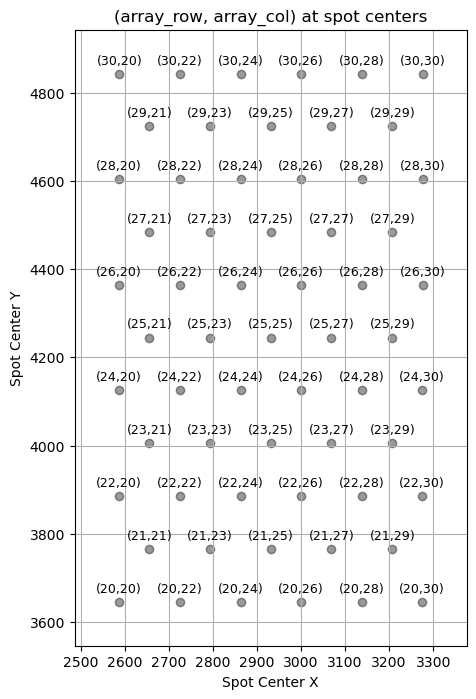

In [12]:
# subset the DataFrame to focus on a smaller region of the data
subset_df = spot_df[(spot_df["array_col"].between(20, 30)) & (spot_df["array_row"].between(20, 30))]

# create the plot
plt.figure(figsize=(10, 8))
for _, row in subset_df.iterrows():
    x, y = row["spot_center_x"], row["spot_center_y"]
    label = f"({row['array_row']},{row['array_col']})"
    plt.text(x, y + 30, label, fontsize=9, ha="center", va="center")
    plt.scatter(x, y, c="k", alpha=0.4)

# set plot limits and labels
plt.xlim(subset_df["spot_center_x"].min() - 100, subset_df["spot_center_x"].max() + 100)
plt.ylim(subset_df["spot_center_y"].min() - 100, subset_df["spot_center_y"].max() + 100)
plt.xlabel("Spot Center X")
plt.ylabel("Spot Center Y")
plt.title("(array_row, array_col) at spot centers")
plt.grid(True)
ax = plt.gca()
ax.set_aspect("equal", "box")

plt.show()

Now that we know spot centers and the radius, let's contruct the Shapes element for the `SpatialData` object. To do so we will call the parser from `ShapesModel`.

In [13]:
df = pd.DataFrame([radius] * len(centers), columns=["radius"])
gdf = gpd.GeoDataFrame(df, geometry=[Point(x, y) for x, y in centers])
shapes_for_sdata = ShapesModel.parse(gdf)
shapes_for_sdata

,radius,geometry
0,37.84375,POINT (8230 7237)
1,37.84375,POINT (4170 1611)
2,37.84375,POINT (2519 8315)
3,37.84375,POINT (7679 2927)
4,37.84375,POINT (3138 6280)
...,...,...
2683,37.84375,POINT (6509 4963)
2684,37.84375,POINT (4101 8195)
2685,37.84375,POINT (3276 8435)
2686,37.84375,POINT (3069 6639)


## 3) Prepare and connect the `AnnData` to the rest of the data

In [14]:
import contextlib

# remove remnants of previous way to store spatial data
with contextlib.suppress(KeyError):
    del adata.uns["spatial"]

with contextlib.suppress(KeyError):
    del adata.obsm["spatial"]

In [15]:
adata_for_sdata = TableModel.parse(adata)

### Connect the `AnnData` to the `Shapes` object

In [16]:
adata_for_sdata.uns["spatialdata_attrs"] = {
    "region": "spots",  # name of the Shapes element we will use later (i.e. the object with centers
    # and radii of the Visium spots)
    "region_key": "region",  # column in adata.obs that will link a given obs to the elements it annotates
    "instance_key": "spot_id",  # column that matches a given obs in the table to a given circle
}
# all the rows of adata annotate the same element, called "spots" (as we declared above)
adata.obs["region"] = pd.Categorical(["spots"] * len(adata))
adata.obs["spot_id"] = shapes_for_sdata.index
adata.obs[["region", "spot_id"]]

,region,spot_id
AAACAAGTATCTCCCA-1,spots,0
AAACAATCTACTAGCA-1,spots,1
AAACACCAATAACTGC-1,spots,2
AAACAGAGCGACTCCT-1,spots,3
AAACCGGGTAGGTACC-1,spots,4
...,...,...
TTGTTGTGTGTCAAGA-1,spots,2683
TTGTTTCACATCCAGG-1,spots,2684
TTGTTTCATTAGTCTA-1,spots,2685
TTGTTTCCATACAACT-1,spots,2686


In [17]:
shapes_for_sdata

,radius,geometry
0,37.84375,POINT (8230 7237)
1,37.84375,POINT (4170 1611)
2,37.84375,POINT (2519 8315)
3,37.84375,POINT (7679 2927)
4,37.84375,POINT (3138 6280)
...,...,...
2683,37.84375,POINT (6509 4963)
2684,37.84375,POINT (4101 8195)
2685,37.84375,POINT (3276 8435)
2686,37.84375,POINT (3069 6639)


We see that the `spot_id` column matches the `index` of the `Shapes` object. This way, we can color the individual circles f.e. by expression values stored in the `AnnData` object.

## 4) Create and visualise the `SpatialData` object

In [18]:
sdata = sd.SpatialData(
    images={"hne": img_for_sdata},
    shapes={"spots": shapes_for_sdata},
    tables={"adata": adata_for_sdata},
)
sdata

SpatialData object
├── Images
│     └── 'hne': DataTree[cyx] (3, 11757, 11291), (3, 5878, 5645), (3, 2939, 2822), (3, 1469, 1411)
├── Shapes
│     └── 'spots': GeoDataFrame shape: (2688, 2) (2D shapes)
└── Tables
      └── 'adata': AnnData (2688, 18078)
with coordinate systems:
    ▸ 'global', with elements:
        hne (Images), spots (Shapes)

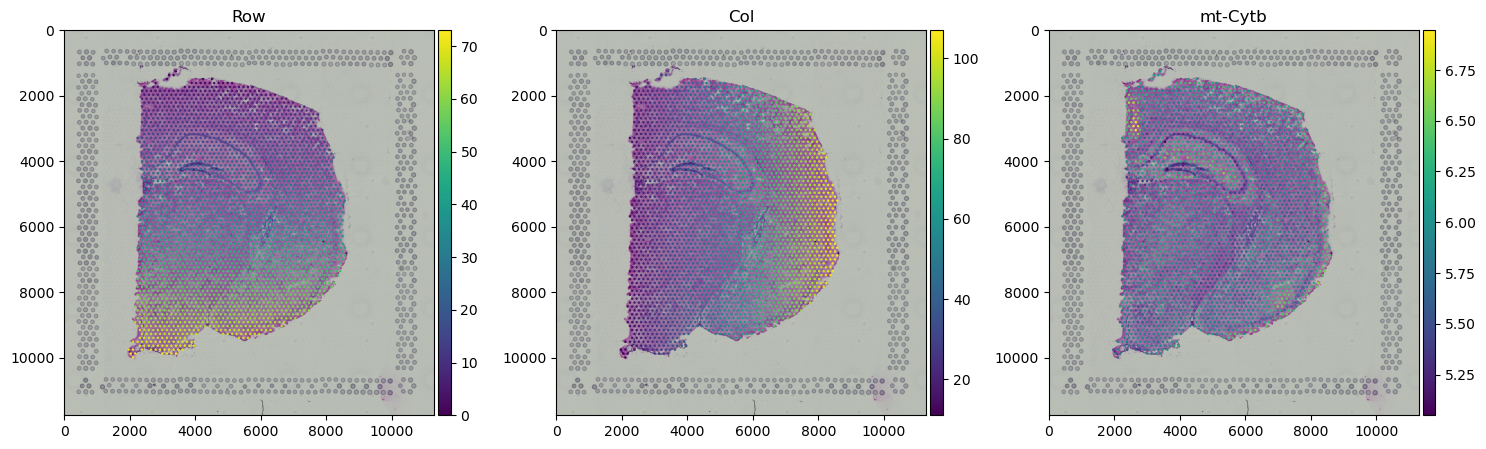

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sdata.pl.render_images().pl.render_shapes(color="array_row").pl.show(ax=axs[0], title="Row")

sdata.pl.render_images().pl.render_shapes(color="array_col").pl.show(ax=axs[1], title="Col")

sdata.pl.render_images().pl.render_shapes(color="mt-Cytb").pl.show(ax=axs[2], title="mt-Cytb")

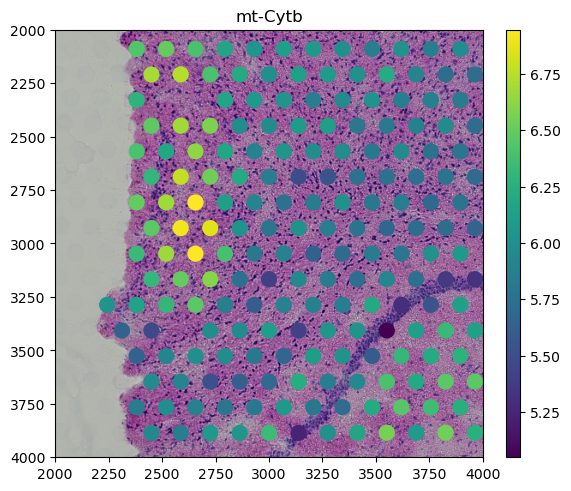

In [20]:
sdata_crop = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[2000, 2000],
    max_coordinate=[4000, 4000],
    target_coordinate_system="global",
)
sdata_crop.pl.render_images().pl.render_shapes(color="mt-Cytb").pl.show(title="mt-Cytb")

In [21]:
sdata.write("./visium_hne_sdata.zarr", overwrite=True)

INFO     The Zarr backing store has been changed from None the new file path: visium_hne_sdata.zarr                


### For reproducibility

In [22]:
%load_ext watermark
%watermark -v -m -p squidpy,spatialdata,spatialdata_plot,matplotlib,geopandas,shapely,pandas,xarray

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.26.0

squidpy         : 1.6.2
spatialdata     : 0.2.5.post0
spatialdata_plot: 0.2.6
matplotlib      : 3.9.2
geopandas       : 1.0.1
shapely         : 2.0.6
pandas          : 2.2.2
xarray          : 2024.9.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

